# PyOpenCAP tutorial
In this tutorial we, post process results from an XMS-CASPT2 calculation from OpenMolcas to perform CAP/XMS-CASPT2 calculations on the ${}^2\Pi_g$ shape resonance of $N_2^-$.

In [3]:
import pyopencap
import numpy as np
from pandas import DataFrame
import h5py

# Constructing the system object
The System object of PyOpenCAP contains the geometry and basis set information, as well as the overlap matrix. The constructor exposed to Python takes in a Python dictionary as an argument, with key/value pairs which mimic the input file format of the command line version. There are three equivalent ways of specifying the geometry and basis set: rassi_h5, molden, and inline. Here, we’ll use the rassi_h5 file.

In [5]:
RASSI_FILE = "n2.rassi.h5"
OUTPUT_FILE = "n2.out"
sys_dict = {"molecule": "molcas_rassi","basis_file": RASSI_FILE}
s = pyopencap.System(sys_dict)
smat = s.get_overlap_mat()
np.shape(smat)

(119, 119)

# Constructing the CAP object
The CAP matrix is computed by the “CAP” object. The constructor for the CAP object requires a System object, a dictionary containing the CAP parameters, the number of states (10 in this case), and finally the string “openmolcas”, which denotes the ordering of the atomic orbital basis set.

In [6]:
cap_dict = {"cap_type": "box",
        "cap_x":"2.76",
        "cap_y":"2.76",
        "cap_z":"4.88",
        "Radial_precision": "14",
        "angular_points": "110"}
pc = pyopencap.CAP(s,cap_dict,10,"openmolcas")

# Parsing electronic structure data from file

The “read_data” function of the CAP object can read in the effective Hamiltonian and densities in one-shot when passed a Python dictionary with the right keywords. For now, we’ll retrieve the effective Hamiltonian and store it as h0 for later use.

In [7]:
es_dict = {"method" : "ms-caspt2",
       "molcas_output":OUTPUT_FILE,
       "rassi_h5":RASSI_FILE}
pc.read_data(es_dict)
h0 = pc.get_H()

Successfully read in zeroth order Hamiltonian from file:n2.out
Reading densities from file:n2.rassi.h5
Done.
Verified overlap matrix.


# Passing densities in RAM

Alternatively, one can load in the densities one at a time using the “add_tdms or add_tdm” functions. We load in the matrices from rassi.h5 using the h5py package, and then pass them as numpy arrays to the CAP object. This can be particularly useful if we want to exclude some of the states from the Perturbative CAP calculation. In this example, the CAP matrix is made to be symmetric.

In [8]:
f = h5py.File(RASSI_FILE, 'r')
dms = f["SFS_TRANSITION_DENSITIES"]
pc = pyopencap.CAP(s,cap_dict,10,"openmolcas")
for i in range(0,10):
    for j in range(i,10):
        dm_alpha = 0.5*np.reshape(dms[i][j],(119,119))
        dm_beta =  0.5*np.reshape(dms[i][j],(119,119))
        pc.add_tdms(dm_alpha,dm_beta,i,j,"openmolcas",RASSI_FILE)
        if i!=j:
            pc.add_tdms(dm_alpha,dm_beta,j,i,"openmolcas",RASSI_FILE)

Once all of the densities are loaded, the CAP matrix is computed using the “compute_perturb_cap” function. The matrix can be retrieved using the “get_perturb_cap” function.

In [13]:
pc.compute_perturb_cap()
W=pc.get_perturb_cap()

Now lets print out our final results.

In [14]:
print("Printing out matrices required for Perturbative CAP calculation.")
print("Number of states: 10")
print("Zeroth order Hamiltonian")
print(DataFrame(h0).to_string(index=False, header=False))
print("CAP matrix")
print(DataFrame(W_mat).to_string(index=False, header=False))

Printing out matrices required for Perturbative CAP calculation.
Number of states: 10
Zeroth order Hamiltonian
-1.093075e+02 -0.000000e+00   -0.009865    0.000194   -0.002573   -0.000044  1.327900e-04  9.700000e-07   -0.000000   -0.000000
-0.000000e+00 -1.093075e+02   -0.000194   -0.009865    0.000044   -0.002573  9.700000e-07 -1.327900e-04   -0.000000   -0.000000
-9.865010e-03 -1.935300e-04 -109.250701   -0.000000    0.031362    0.001074  6.621930e-03 -2.309800e-04   -0.000000    0.000000
 1.935300e-04 -9.865020e-03   -0.000000 -109.250701   -0.001074    0.031362 -2.309700e-04 -6.621950e-03   -0.000000    0.000000
-2.572670e-03  4.448000e-05    0.031362   -0.001074 -109.225978   -0.000000 -3.950227e-02  1.115000e-05    0.000000   -0.000000
-4.448000e-05 -2.572660e-03    0.001074    0.031362   -0.000000 -109.225978  1.115000e-05  3.950231e-02    0.000000   -0.000000
 1.327900e-04  9.700000e-07    0.006622   -0.000231   -0.039502    0.000011 -1.090686e+02  0.000000e+00    0.000000   -0.

# Eigenvalue trajectories

In [18]:
from pyopencap.analysis import CAPHamiltonian
import matplotlib.pyplot as plt

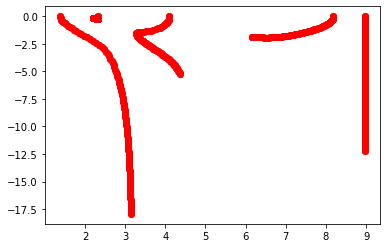

In [24]:
ref_energy = -109.36009153
eta_list = np.linspace(0,1000,101)
eta_list = eta_list * 1E-5
CAPH = CAPHamiltonian(H0=h0,W=W)
CAPH.run_trajectory(eta_list)
plt.plot(np.real(CAPH.energies_ev(ref_energy=ref_energy)),np.imag(CAPH.energies_ev(ref_energy=ref_energy)),'ro',label='Uncorrected Trajectory')
plt.show()

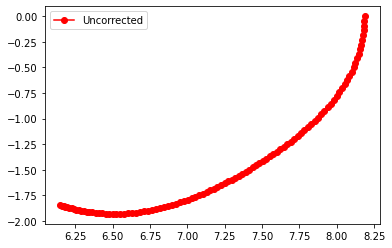

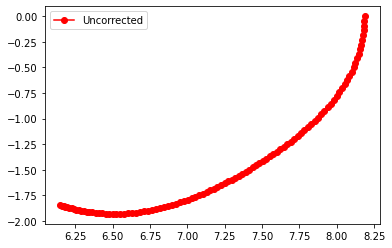

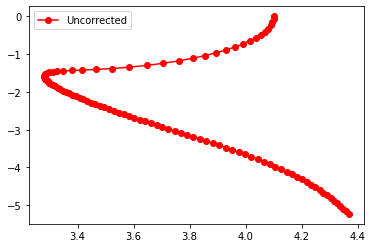

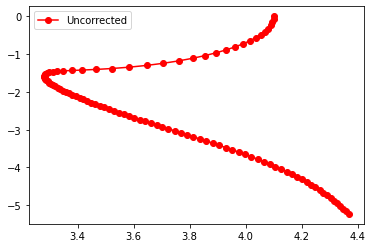

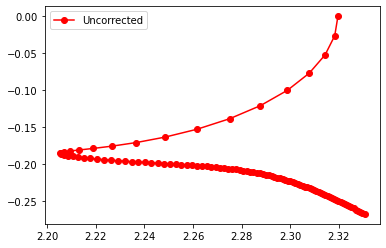

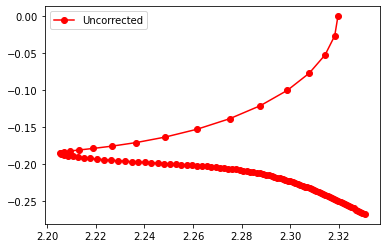

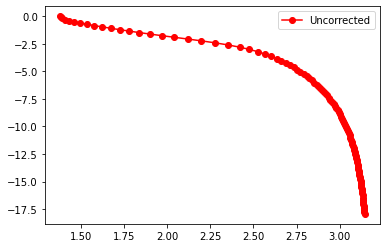

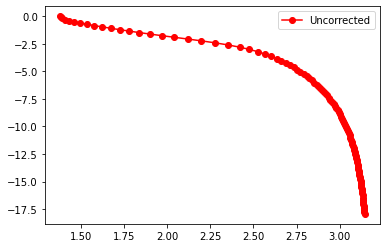

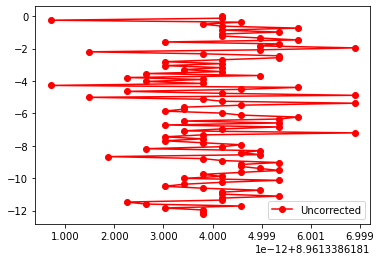

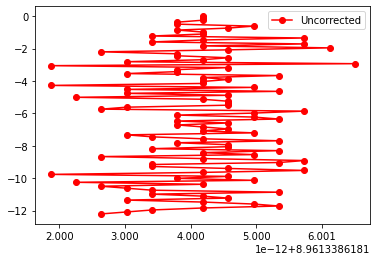

In [25]:
for i in range(0,10):
    traj = CAPH.track_state(i,tracking="overlap")
    uc_energies = traj.energies_ev(ref_energy=ref_energy)
    plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
    plt.legend()
    plt.show()

Uncorrected:
(2.2053071552729113-0.18532097564536146j)
0.0016
Corrected:
(2.151993535297524-0.17723651408570337j)
0.0027


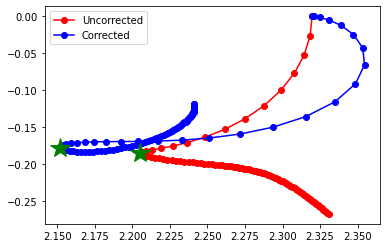

In [26]:
traj = CAPH.track_state(5,tracking="overlap")
uc_energies = traj.energies_ev(ref_energy=ref_energy)
corr_energies = traj.energies_ev(ref_energy=ref_energy,corrected=True)
uc_energy, eta_opt = traj.find_eta_opt(start_idx=10)
uc_energy = (uc_energy-ref_energy)*27.2114
corr_energy, corr_eta_opt = traj.find_eta_opt(corrected=True,start_idx=10)
corr_energy = (corr_energy-ref_energy)*27.2114
print("Uncorrected:")
print(uc_energy)
print(eta_opt)
print("Corrected:")
print(corr_energy)
print(corr_eta_opt)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.plot(np.real(uc_energy),np.imag(uc_energy),'g*',markersize=20)
plt.plot(np.real(corr_energy),np.imag(corr_energy),'g*',markersize=20)
plt.legend()
plt.show()